# Adam Net  - MLP/FFN ( 2-layer, Adam, tanh )

In [1]:
import numpy as np
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random

#### Utilitiy Functions - Dataset Loader Function and other functions

In [2]:
def load_train_data(base_path, img_size=(32, 32)):
    class_folders = sorted(os.listdir(base_path))
    images = []
    labels = []
    for class_name in class_folders:
        class_path = os.path.join(base_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)
                img_array = np.asarray(img).flatten()
                images.append(img_array)
                labels.append(int(class_name))
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    X = np.array(images) / 255.0
    y = np.array(labels)
    lb = LabelBinarizer()
    y = lb.fit_transform(y)
    return X, y

#### Train - Test - Val Split

In [3]:
def split_train_val(X, y, val_size=0.2):
    return train_test_split(X, y, test_size=val_size, random_state=42)

#### Plotting the results

In [4]:
def plot_curves(train_acc, val_acc, train_loss, val_loss, title='AdamNet'):
    epochs = np.arange(1, len(train_acc)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Adam Net Model - MLP/FFN ( 2-layer, Adam, tanh )

In [5]:
class AdamNet:
    def __init__(self, input_size, hidden1, output_size, learning_rate=0.001):
        self.W1 = np.random.randn(input_size, hidden1) * np.sqrt(2. / input_size)
        self.b1 = np.zeros(hidden1)
        self.W2 = np.random.randn(hidden1, output_size) * np.sqrt(2. / hidden1)
        self.b2 = np.zeros(output_size)
        self.m = {'W1': 0, 'b1': 0, 'W2': 0, 'b2': 0}
        self.v = {'W1': 0, 'b1': 0, 'W2': 0, 'b2': 0}
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.eps = 1e-8
        self.t = 0
        self.learning_rate = learning_rate

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x):
        ex = np.exp(x - np.max(x, axis=1, keepdims=True))
        return ex / ex.sum(axis=1, keepdims=True)

    def cross_entropy(self, y_true, y_pred):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

    def accuracy(self, y_true, y_pred):
        return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

    def forward(self, X):
        self.X = X
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.tanh(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def backward(self, X, y, lr=None):
        if lr is None:
            lr = self.learning_rate
        m = X.shape[0]
        self.t += 1
        dz2 = (self.a2 - y) / m
        dW2 = self.a1.T @ dz2
        db2 = np.sum(dz2, axis=0)
        dz1 = dz2 @ self.W2.T * self.tanh_derivative(self.z1)
        dW1 = X.T @ dz1
        db1 = np.sum(dz1, axis=0)
        # Adam update for W2
        self.m['W2'] = self.beta1 * self.m['W2'] + (1 - self.beta1) * dW2
        self.v['W2'] = self.beta2 * self.v['W2'] + (1 - self.beta2) * (dW2**2)
        m_hat = self.m['W2'] / (1 - self.beta1**self.t)
        v_hat = self.v['W2'] / (1 - self.beta2**self.t)
        self.W2 -= lr * m_hat / (np.sqrt(v_hat) + self.eps)
        # Adam update for b2
        self.m['b2'] = self.beta1 * self.m['b2'] + (1 - self.beta1) * db2
        self.v['b2'] = self.beta2 * self.v['b2'] + (1 - self.beta2) * (db2**2)
        m_hat = self.m['b2'] / (1 - self.beta1**self.t)
        v_hat = self.v['b2'] / (1 - self.beta2**self.t)
        self.b2 -= lr * m_hat / (np.sqrt(v_hat) + self.eps)
        # Adam update for W1
        self.m['W1'] = self.beta1 * self.m['W1'] + (1 - self.beta1) * dW1
        self.v['W1'] = self.beta2 * self.v['W1'] + (1 - self.beta2) * (dW1**2)
        m_hat = self.m['W1'] / (1 - self.beta1**self.t)
        v_hat = self.v['W1'] / (1 - self.beta2**self.t)
        self.W1 -= lr * m_hat / (np.sqrt(v_hat) + self.eps)
        # Adam update for b1
        self.m['b1'] = self.beta1 * self.m['b1'] + (1 - self.beta1) * db1
        self.v['b1'] = self.beta2 * self.v['b1'] + (1 - self.beta2) * (db1**2)
        m_hat = self.m['b1'] / (1 - self.beta1**self.t)
        v_hat = self.v['b1'] / (1 - self.beta2**self.t)
        self.b1 -= lr * m_hat / (np.sqrt(v_hat) + self.eps)

#### Training the model

In [6]:
def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=128):
    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    n_samples = X_train.shape[0]
    n_batches = n_samples // batch_size
    for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        for i in range(n_batches):
            start = i * batch_size
            end = min(start + batch_size, n_samples)
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]
            self.forward(X_batch)
            self.backward(X_batch, y_batch)
        train_pred = self.forward(X_train)
        val_pred = self.forward(X_val)
        train_acc = self.accuracy(y_train, train_pred)
        val_acc = self.accuracy(y_val, val_pred)
        train_loss = self.cross_entropy(y_train, train_pred)
        val_loss = self.cross_entropy(y_val, val_pred)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    return train_accs, val_accs, train_losses, val_losses

####  Random Search for Hyperparameter Tuning

In [7]:
def random_search_adamnet(X_train, y_train, X_val, y_val, input_size, output_size, n_trials=4):
    param_grid = [
        {'learning_rate': 0.001, 'batch_size': 128, 'hidden1': 512},
        {'learning_rate': 0.001, 'batch_size': 64,  'hidden1': 256},
        {'learning_rate': 0.005, 'batch_size': 128, 'hidden1': 512},
        {'learning_rate': 0.005, 'batch_size': 64,  'hidden1': 256},
    ]
    best_val_acc = 0
    best_histories = None
    best_model = None
    for params in random.sample(param_grid, n_trials):
        print(f"\nTrial AdamNet: {params}")
        model = AdamNet(input_size=input_size, hidden1=params['hidden1'], output_size=output_size, learning_rate=params['learning_rate'])
        train_accs, val_accs, train_losses, val_losses = model.train(X_train, y_train, X_val, y_val, epochs=10, batch_size=params['batch_size'])
        if max(val_accs) > best_val_acc:
            best_val_acc = max(val_accs)
            best_histories = (train_accs, val_accs, train_losses, val_losses)
            best_model = model
    print(f"\nBest AdamNet Val Acc: {best_val_acc:.4f}")
    return best_histories, best_model

#### Main Code


Random Search AdamNet:

Trial AdamNet: {'learning_rate': 0.001, 'batch_size': 64, 'hidden1': 256}
Epoch 1/10 | Train Loss: 0.7981 | Val Loss: 0.8332 | Train Acc: 0.8052 | Val Acc: 0.7902
Epoch 2/10 | Train Loss: 0.4944 | Val Loss: 0.5416 | Train Acc: 0.8875 | Val Acc: 0.8720
Epoch 3/10 | Train Loss: 0.3854 | Val Loss: 0.4326 | Train Acc: 0.9067 | Val Acc: 0.8916
Epoch 4/10 | Train Loss: 0.2962 | Val Loss: 0.3519 | Train Acc: 0.9257 | Val Acc: 0.9078
Epoch 5/10 | Train Loss: 0.2510 | Val Loss: 0.3022 | Train Acc: 0.9405 | Val Acc: 0.9248
Epoch 6/10 | Train Loss: 0.2478 | Val Loss: 0.3021 | Train Acc: 0.9338 | Val Acc: 0.9180
Epoch 7/10 | Train Loss: 0.2335 | Val Loss: 0.2906 | Train Acc: 0.9397 | Val Acc: 0.9227
Epoch 8/10 | Train Loss: 0.1983 | Val Loss: 0.2607 | Train Acc: 0.9516 | Val Acc: 0.9317
Epoch 9/10 | Train Loss: 0.2179 | Val Loss: 0.2784 | Train Acc: 0.9427 | Val Acc: 0.9259
Epoch 10/10 | Train Loss: 0.2000 | Val Loss: 0.2564 | Train Acc: 0.9477 | Val Acc: 0.9262

Trial Ada

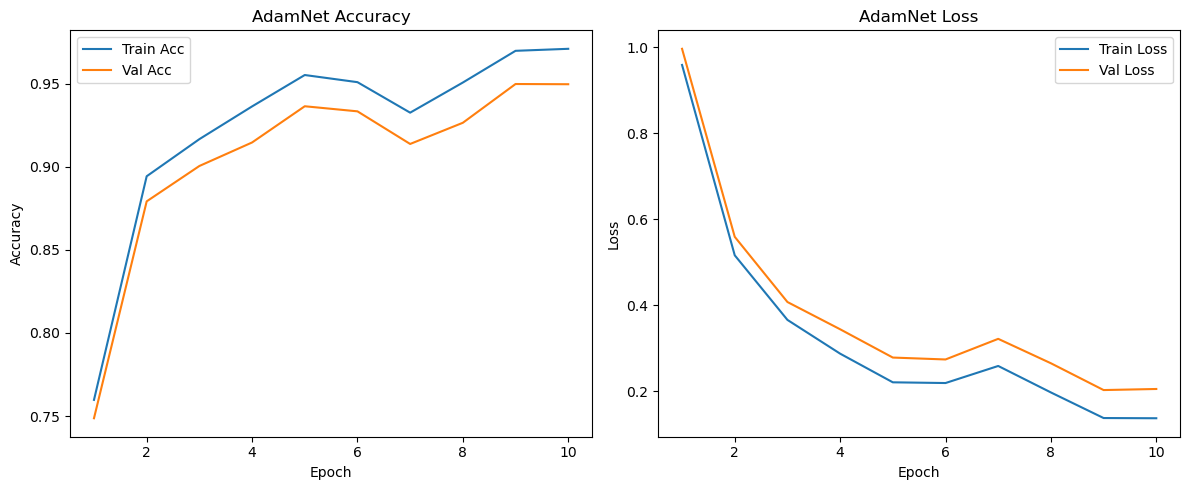

In [3]:
if __name__ == "__main__":
    train_path = "/Users/pavankoushik/Development/University/Neural Networks/Dataset/Train"
    # Load and split train/val
    X, y = load_train_data(train_path)
    X_train, X_val, y_train, y_val = split_train_val(X, y, val_size=0.2)
    print("\nRandom Search AdamNet:")
    histories, best_model = random_search_adamnet(
        X_train, y_train, X_val, y_val, input_size=X_train.shape[1], output_size=y_train.shape[1], n_trials=4
    )
    plot_curves(*histories, title="AdamNet")
